<a href="https://colab.research.google.com/github/jadercaro/Prediccion-colesterol/blob/main/2_Modelo_KNN_Parzen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras alamancenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [ ]:
#@title **Integrantes**
nombres_apellidos_integrante_1 ='Alejandro Arias' #@param {type:"string"}
nombres_apellidos_integrante_2 = 'Jagler Velasquez'  #@param {type:"string"}
nombres_apellidos_integrante_3 = 'Jhon Jader Caro'  #@param {type:"string"}

In [ ]:
#@title **Base de datos**
G_DB_='6' #@param {type:"string"}

In [ ]:
#Importing all the dependencies
%load_ext autoreload
%autoreload 2
in_colab = True
import os
import sys ; sys.path.append('../drive/MyDrive/Colab Notebooks/local/data');
import pandas as pd
import numpy as np
from numpy import random
from matplotlib import pyplot as plt

from scipy.stats import mode
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from numpy import random
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error
from math import sqrt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Parte 2. Problema de regresión**



El objetivo de nuestro estudio de regresión es predecir los niveles de **colesterol** a partir de una serie de características médicas. Seleccioné un conjunto inicial de 12 características potenciales, pero para simplificar el modelo, decidí reducirlo a solo 3 características principales. Estas características fueron seleccionadas debido a su alta correlación de R de Pearson y relación de correlación con respecto a la variable objetivo, que es el nivel de colesterol en sangre.

Las características numéricas que hemos elegido para incluir en nuestro modelo son:

  1. **Presión arterial en reposo en mm Hg al ingreso al hospital** (trestbps) - Númerica

  2. **Edad del paciente** (age) - Númerica

  3. **Depresión del segmento ST inducida por el ejercicio relativa al reposo** (oldpeak) - Númerica

  4. **Colesterol**(chol) - Númerica

In [ ]:
#cargamos la bd
df = pd.read_csv('regresion_preprocesado.csv')
x=df[['age','trestbps','oldpeak']].to_numpy()
y=df['chol'].to_numpy()

In [ ]:
print ("Dimensión de los datos de entrada: ", x.shape[0], 'muestras y', x.shape[1], 'características.')

Dimensión de los datos de entrada:  303 muestras y 3 características.


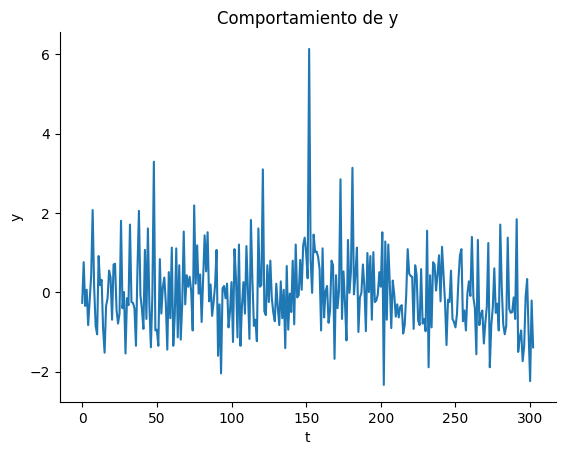

In [ ]:
t = np.arange(0, len(y), 1)
fig, ax = plt.subplots()
plt.plot(t,y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Comportamiento de y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

En los problemas de regresión, es muy útil explorar la distribución de la variable objetivo. Nuestro primer ejercicio consiste en:
1. visualizar un histograma de la variable
2. Usar el histograma para confirmar como están distribuidos los datos


Usa la siguiente celda para ver el comportamiento de la función para responder la pregunta abierta 1.

Pistas:
1. Explorar la documentación de [plt.hist](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html)
2. Puedes copiar y pegar los códigos de las opciones y visualizar resultados y te ayuden a verificar la justificación.

Text(0, 0.5, 'frecuencia')

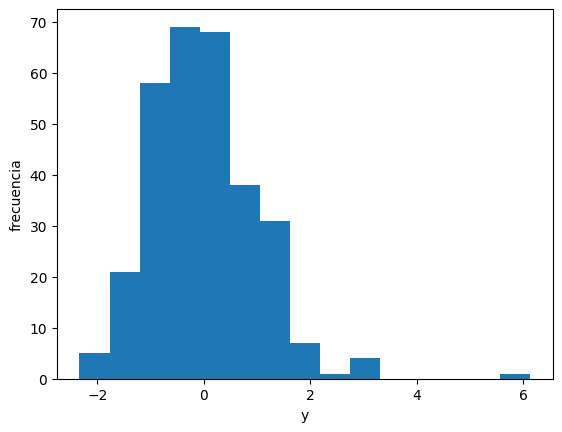

In [ ]:
#Usa esta celda para explorar la función y los datos
n, bins, patches = plt.hist(y, bins = 15)
plt.xlabel('y')
plt.ylabel('frecuencia')

In [ ]:
#@title **1. Pregunta Abierta**
#@markdown Dependiendo de los resultados de tu exploración de la función
#@markdown ¿cuál de las siguientes afirmaciones es correcta?

#@markdown A) `plt.hist(x, bins = 2)` nos muestra la distribución de la variable objetivo usando `2` bins o "cajones", cada bin tiene un color diferente.

#@markdown B) `plt.hist(y, bins = 2)` nos muestra la distribución de la variable objetivo usando `2` bins o "cajones", todos los bines son azules y el eje Y del histograma nos muestra la probabilidad de cada valor

#@markdown C) `plt.hist(y, bins = 15)` nos muestra la distribución de la variable objetivo usando `15` bins o "cajones", todos los bines son azules y el eje `Y` del histograma nos muestra el # de muestra que están en cada rango del eje `X`

#@markdown D) `plt.hist(x, bins = 15, facecolor='b')` nos muestra la distribución de la variable objetivo usando `15` bins o "cajones", todos los bines son azules y el eje `Y` del histograma nos muestra el # de muestra que están en cada rango del eje `X`

#@markdown Selecciona dentro las lista desplegable
respuesta_1 = 'C' #@param ["", "A", "B", "C", "D"]

In [ ]:
#@title **2. Pregunta Abierta**
#@markdown Dependiendo de los resultados de tu exploración usando el histograma,
#@markdown ¿que se puede decir de la distribución de los datos?
#@markdown ¿cuál de las opciones es mejor justificada?

#@markdown A) Nuestra variable de salida puede ser modela mediante una distribución Gaussiana centrada alrededor de `20`. Ya que los valores del rango de `40-50` no tienen tanto peso

#@markdown B) Nuestra variable de salida puede ser modela mediante una distribución Gaussiana centrada alrededor de `50`. Ya que se observa una concentración de datos pequeña dentro del rango de `40-50`

#@markdown C) Se observan una concentración de datos en el rango `40-50` que nos impide asumir una distribución Gaussiana, esto implica que debemos filtrar estos valores, ya que son valores atípicos y sin importar la razón, nuestro modelo no puede tener valores atípicos

#@markdown D) Nuestra variable de salida podría ser modela mediante una distribución Gaussiana centrada alrededor de `20`, sin embargo, esta distribución no podría modelar bien los valores dentro del rango `40-50`

#@markdown Selecciona dentro las lista desplegable
respuesta_2 = 'D' #@param ["", "A", "B", "C", "D"]

Nuestros conjuntos de datos, siempre van a ser derivados de alguna situación, fenómeno o comportamiento del mundo real.

Sin embargo, el resultado de nuestro modelamiento es totalmente influenciado por la calidad de la información usada.

Al usar información que esté sesgada y/o que no represente en su totalidad la situación/comportamiento/fenómeno que queremos modelar, podemos incurrir en errores. Muchas veces los resultados de nuestros modelos van a ser usados para tomar decisiones que van a influenciar directamente la vida de las personas.

En la etapa de exploración, adicional de explorar los datos usando gráficas (como el histograma, scatter plot) y estadísticas, es vital entender la naturaleza y origen de nuestros datos.

Al ejecutar la celda de configuración del laboratorio, debieron observar algunas advertencias acerca del conjunto de datos. Explora un poco más estas advertencias en la documentación: [link text](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html)




In [ ]:
#@title **3. Pregunta Abierta**
#@markdown En tus palabras, ¿por qué usar este conjunto de datos tiene implicaciones éticas?
respuesta_3 = "En nuestro caso, usar este conjunto de datos tiene implicaciones eticas ya un mal desempeño del modelo estando en producción puede desinformar acerca del nivel de colesterol y poner en riesgo la salud de los pacientes" #@param {type:"string"}

## **Experimentar con KNN**

**Vamos a implementar ahora KNN para un problema de regresión.**

Las mismas pistas de nuestro laboratorio anterior son de utilidad para implementar el algoritmo.

1. Para el cáculo de la distancia entre vectores existen varias opciones:
    1. usar la función la distancia entre matrices `scipy.spatial.distance.cdist`([Ejemplo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist))--esta puede ser usada directamente como `cdist(...)`. Entiende la salida de esta función. Al usarla, se logra un rendimiento superior.
    2. usar la función la distancia euclidiana `scipy.spatial.distance.euclidean`([Ejemplo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html))--pueder acceder a ella directamente como `euclidean`. Aca debe pensar en un algoritmo elemento a elemento, por lo tanto menos eficiente.
2. También serán de utilidad las funciones `np.sort` y `np.argsort`.
3. ¿cual es la unica diferencia entre el knn para clasificación y regresión? en lugar de la moda, que metodo debemos usar?

In [ ]:
#ejercicio de código
def KNN_regresion(Xtrain, Ytrain, Xtest, k):
    """ Funcion que implementa el modelo de K-Vecino mas cercanos
        para regresión

    args:
        Xtrain: es la matriz con las muestras de entrenamiento
        Ytrain: es un vector con los valores de salida para cada una de las muestras de entrenamiento
        Xtest: es la matriz con las muestras de validación
        k (int): valor de vecinos a usar

    retorna: las estimaciones del modelo KNN para el conjunto Xtest
             esta matriz debe tener un shape de [row/muestras de Xtest]
             y las distancias de Xtest respecto a Xtrain, estan matrix
             debe tener un shape de [rows de Xtest, rows Xtrain]
             lo que es lo mismo [muestras de Xtest, muestras de Xtrain]
    """
    from scipy.spatial import distance
    if k > Xtrain.shape[0]:
        print("k no puede ser menor que las muestras de entrenamiento")
        return(None)

    distancias = distance.cdist(Xtest,Xtrain)
    Yest = np.zeros(Xtest.shape[0])
    for i in range(len(Xtest)):
      aux=Ytrain[np.argsort(distancias[i])[:k]]
      Yest[i]=sum(aux[:k])/k
    return Yest, distancias

**Calculemos el error de nuestro modelo**

In [ ]:
def MAPE(Y_est,Y):
    """Mean Absolute Percentage Error para los problemas de regresión
    Y_est: numpy array con los valores estimados
    Y: numpy array con las etiquetas verdaderas
    retorna: mape
    """
    N = np.size(Y)
    mape = np.sum(abs((Y_est.reshape(N,1) - Y.reshape(N,1))/Y.reshape(N,1)))/N
    return mape

In [ ]:
#@title **4. Pregunta Abierta**
#@markdown En sus palabras, ¿Cómo se puede explicar el MAPE? ¿Cuáles son los valores para el caso de un modelo perfecto? ¿cuáles son los valores para un modelo con falta de entrenamiento?
respuesta_4 = "Es la métrica que mide el error absoluto en términos de porcentaje, para que un modelo sea perfecto, la diferencia entre Y estimado y Y real debe ser cero o muy cercano a 0, es  decir pocos fallos, el caso contrario para que un modelo tenga signos de falta de entrenamiento es cuando el valor absoluto de la suma de las diferencias entre los valores de Y estimado y Y real son my grandes " #@param {type:"string"}

Vamos a crear la función para experimentar.

En el ejercicio de código, se puede observar que usamos nuevamente la funciónes de la libreria **sklearn**:

1. [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) para normalizar.

2. [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Para dividir el conjunto de datos. Entiende como estamos usando esta función y completa el codigo para realizar 5 repeticiones.

In [ ]:
#Ejercicio de código
def experimentar (ks, X, Y):
    """Función que realiza los experimentos con knn usando
       una estrategia de validacion entrenamiento y pruebas

    ks: List[int/float] lista con los valores de k-vecinos a usar
    X: matriz de numpy conjunto con muestras y caracteristicas
    Y: vector de numpy con los valores a predecir
    retorna: dataframe con los resultados, debe contener las siguientes columnas:
        - los k-vecinos, el error-mape medio de prueba, la desviacion estandar del error-mape
    """

    resultados = pd.DataFrame()
    idx = 0
    # iteramos sobre la lista de k's
    for k in ks:

        # iteramos para validar
        # sobre las particiones
        # ¿que numero debemos asignar para lograr las particiones?
        for j in range(5):
            # dividimos usando la función
            Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, random_state=0, test_size=0.2)
            scaler = StandardScaler()
            scaler.fit(Xtrain)
            Xtrain= scaler.transform(Xtrain)
            Xtest = scaler.transform(Xtest)

            Yest, _ =  KNN_regresion(Xtrain, Ytrain, Xtest, k)
            errorTest = MAPE(Yest,Ytest)
            error_RECM = sqrt(mean_squared_error(Ytest,Yest))

            resultados.loc[idx,'k-vecinos'] = k
            resultados.loc[idx,'error en conjunto de prueba'] = errorTest
            resultados.loc[idx, 'RECM'] = error_RECM
            #asignamos la particion
            resultados.loc[idx, 'repeticion'] = j
            idx+=1
    return (resultados)

In [ ]:
#@title **5. Pregunta Abierta**
#@markdown  Observa nuevamente el código y concentrate en la metodología de validación
#@markdown ¿cuál de las siguientes opciones es la mejor justificada?

#@markdown A) Al usar la función `train_test_split` estamos asegurando implementar la metodología de validación básica de la división entre conjunto de prueba y entrenamiento.

#@markdown B)  Al usar la función `train_test_split` con 5 repeticiones estamos implementando la metodología Bootstrapping.

#@markdown C) Estamos realizando validación cruzada, ya que estamos usando particiones del conjunto original de datos

#@markdown D) Al usar la función `train_test_split` 5 veces, estamos realizando 5 particiones por lo tanto estamos usando validación cruzada

#@markdown Selecciona dentro las lista desplegable
respuesta_5 = 'A' #@param ["", "A", "B", "C", "D"]

Al plantar la semilla al hacer la partición con train test split, las 5 iteraciones se van a entrenar y validar con el mismo conjunto de datos y por ende las 5 validaciones daran el mismo resultado :)

Ahora ejecuta los experimentos con k = 2,3,4,5,6,7,10

In [ ]:
resultados = experimentar ([15,18,22,30,39], x, y)
resultados

,k-vecinos,error en conjunto de prueba,RECM,repeticion
0,15.0,0.144637,58.782059,0.0
1,15.0,0.144637,58.782059,1.0
2,15.0,0.144637,58.782059,2.0
3,15.0,0.144637,58.782059,3.0
4,15.0,0.144637,58.782059,4.0
5,18.0,0.142224,58.255541,0.0
6,18.0,0.142224,58.255541,1.0
7,18.0,0.142224,58.255541,2.0
8,18.0,0.142224,58.255541,3.0
9,18.0,0.142224,58.255541,4.0


## **Experimentar con Parzen**


Ahora, igualmente, vamos aplicar ventana de parzen para resolver el problema de regresión.

$$f({\bf{x}}^*) = \frac{1}{N h^d} \sum_{i=1}^{N} K(u_i), \;\; u_i = \frac{d({\bf{x}}^*,{\bf{x}}_i)}{h}$$

En la siguiente celda se define la función para un $K(u_i)$ gaussiano y se realiza la sugerencia para estimar el termino $ \sum_{i=1}^{N} K(u_i)$, siendo $\;\; u_i = \frac{d({\bf{x}}^*,{\bf{x}}_i)}{h}$.

Observa y entiende esta última función y sus argumentos. Recordando que para regresión, debemos usar la relación de **Nadaraya_Watson**.

$$y^* = \frac{\sum_{i=1}^N K(u_i)y_i}{\sum_{i=1}^N K(u_i)} $$



Usando las anteriores funciones, completa el código.

In [ ]:
def kernel_gaussiano(x):
    return (np.exp((-0.5)*x**2))

def ParzenWindow(x,Data,h,Datay=None):
    """"ventana de parzen
    Args:
        x: vector con representando una sola muestra
        Data: vector de muestras de entrenamiento
        h: ancho de la ventana de kernel
        Datay: vector con los valores de salida (y), Si no se pasa como argumento,
            se calcula un ventana de parzen sin multiplicar los valores de este vector.

    Retorna: el valor de ventana de parzen para una muestra
    """
    h = h
    Ns = Data.shape[0]
    suma = 0
    for k in range(Ns):
        u = euclidean(x,Data[k,:])
        if Datay is None:
            suma += kernel_gaussiano(u/h)
        else:
            suma += kernel_gaussiano(u/h)*Datay[k]
    return suma

In [ ]:
#Ejercicio de código
def Nadaraya_Watson(h, Xtrain, Ytrain, Xtest):
    """ Funcion que implementa metodo de ventana de parzen para
        para clasificación
    Args
        h (float): ancho de h de la ventana
        Xtrain: es la matriz con las muestras de entrenamiento
        Ytrain: es un vector con los valores de salida pra cada una de las muestras de entrenamiento
        Xtest: es la matriz con las muestras de validación

    retorna: - las estimaciones del modelo parzen para el conjunto Xtest
              esta matriz debe tener un shape de [row/muestras de Xtest]
    """

    Yest = np.zeros(Xtest.shape[0])
    for i in range(len(Yest)):
      Yest[i]= ParzenWindow(Xtest[i], Xtrain, h, Ytrain)/ParzenWindow(Xtest[i], Xtrain, h)

    #Debe retornar un vector que contenga las predicciones para cada una de las muestras en X_val, en el mismo orden.
    return Yest

En el ejercicio anterior, se puede observar que usamos nuevamente la funciónes de la libreria **sklearn**:

1. [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) para normalizar.
2. Y se debe usar la función [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold) para realizar la validación.

In [ ]:
def experimentarParzen (hs, X, Y):
    """Función que realiza los experimentos con knn usando
       una estrategia de validacion entrenamiento y pruebas

    hs: List[int/float] lista con los valores de h a usar
    X: matriz de numpy conjunto con muestras y caracteristicas
    Y: vector de numpy con los valores de las etiquetas

    retorna: dataframe con los resultados, debe contener las siguientes columnas:
        - el ancho de ventana,
        - el error medio de prueba
        - la desviacion estandar del error
        - número de promedio en el conjunto de prueba/validacion
    """
    # se usa la función para implementar la estrategia de validación.
    # asgine el valor acorde
    kfolds = KFold(n_splits=3)
    resultados = pd.DataFrame()
    idx = 0
    # iteramos sobre los valores de hs

    for h in hs:

        #contador para cada particion
        particion = 0
        # asigne el valor al parametro X
        for train, test in kfolds.split(X, Y):

            # como usar train y test ?
            Xtrain = X[train,:]
            Ytrain = Y[train]
            Xtest = X[test,:]
            Ytest = Y[test]
            #normalizamos los datos
            scaler = StandardScaler()
            scaler.fit(Xtrain)
            Xtrain = scaler.transform(Xtrain)
            Xtest = scaler.transform(Xtest)

            Yest = Nadaraya_Watson(h, Xtrain, Ytrain, Xtest)
            errorTest = MAPE(Yest, Ytest)
            error_MECR = sqrt(mean_squared_error(Ytest,Yest))


            resultados.loc[idx,'ancho de ventana'] = h
            resultados.loc[idx,'error en conjunto de prueba'] = errorTest
            resultados.loc[idx, 'RECM'] = error_MECR
            resultados.loc[idx,'particion'] = particion
            idx+=1
            particion+=1
    return (resultados)

In [ ]:
#@title **6. Pregunta Abierta**
#@markdown Usando la función KFold implementamos la metodología de cross-validación o validación cruzada, ¿qué implicaciones tiene configurar esta función con `shuffle=True`?
respuesta_6 = "Aleatoriza o baraja los datos para evitar sesgos con respecto al orden en el que se encuentran antes de dividirlo en los Folders evitando que vayan a quedar particiones sin muestras de alguna de las clases" #@param {type:"string"}

In [ ]:
#@title **7. Pregunta Abierta**
#@markdown En sus palabras, ¿cuál es la principal diferencia entre la metodología de validación cruzada y la metodología usada en el ejercicio 3 de código?
respuesta_7 = "" #@param {type:"string"}

In [ ]:
# ejecute para ver los experimentos
#hs = [1,1.5 ,2.5, 5, 10]
hs = [1,1.5,2.5,4,5,7,10]
experimentos_parzen = experimentarParzen(hs, x,y)
experimentos_parzen

,ancho de ventana,error en conjunto de prueba,RECM,particion
0,1.0,0.159666,48.834265,0.0
1,1.0,0.148528,59.224907,1.0
2,1.0,0.201975,50.584240,2.0
3,1.5,0.158017,48.586718,0.0
4,1.5,0.148936,58.853972,1.0
5,1.5,0.200629,49.867906,2.0
6,2.5,0.157775,48.553794,0.0
7,2.5,0.150776,59.274445,1.0
8,2.5,0.200665,49.589062,2.0
9,4.0,0.157916,48.593609,0.0


In [ ]:
# para ver el mejor modelo
# vamos a calcular el valor medio
# Y order acorde y observamos
# el primer valor

col_para_ordenar = 'RECM'

(experimentos_parzen
 .groupby(['ancho de ventana'], as_index=False)[col_para_ordenar].mean()
 .sort_values(by=col_para_ordenar, ascending = True)
 .head(5))

,ancho de ventana,RECM
1,1.5,52.436199
2,2.5,52.472434
3,4.0,52.578335
4,5.0,52.614111
5,7.0,52.649068


In [ ]:
# para ver el mejor modelo
# vamos a calcular el valor medio
# Y order acorde y observamos
# el primer valor

col_para_ordenar = 'error en conjunto de prueba'

(experimentos_parzen
 .groupby(['ancho de ventana'], as_index=False)[col_para_ordenar].mean()
 .sort_values(by=col_para_ordenar, ascending = True)
 .head(5))

,ancho de ventana,error en conjunto de prueba
1,1.5,0.169194
2,2.5,0.169739
0,1.0,0.170056
3,4.0,0.170177
4,5.0,0.170306


In [ ]:
col_para_ordenar = 'RECM'

(experimentos_parzen
 .groupby(['ancho de ventana'], as_index=False)[col_para_ordenar].std()
 .sort_values(by=col_para_ordenar, ascending = True)
 .head(5))

,ancho de ventana,RECM
0,1.0,5.563108
1,1.5,5.594750
2,2.5,5.913414
3,4.0,6.083003
4,5.0,6.128067
